In [3]:
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.stats import norm
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
from copulae1 import *
from KDEs import *
from toolbox import *
import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv('../processed_data/btc_future_crix.csv')
data.head()
data = data.iloc[-252:,:]
data.return_brr = data.return_brr.iloc[-252:].values
data.return_btc = data.return_btc.iloc[-252:].values

ecdf_brr = ECDF(data.return_brr.values)
ecdf_btc = ECDF(data.return_btc.values)

u_arr = ecdf_brr(data.return_brr.values)
v_arr = ecdf_btc(data.return_btc.values)

kde_brr = KDE(data.return_brr.values, "Gaussian")
kde_btc = KDE(data.return_btc.values, "Gaussian")

In [94]:
# Moments
tau_target = [stats.kendalltau(data.return_brr, data.return_btc)[0]]
# q_arr = [0.01,0.1,0.2,0.8,0.9,.99]
q_arr = [0.05,.1,.9,0.95]
_lambda_arr = [empirical_lambda(u_arr, v_arr, q) for q in q_arr]
m_emp = np.array(tau_target+_lambda_arr)
print(m_emp)

[0.56455524 0.55813953 0.63565891 0.62015504 0.58914729]


In [95]:
#alpha beta delta
#delta --> rank 

$Loss = g g^\intercal$

$g(\theta) = \hat{m}(\theta) - m$

In [111]:
def loss(C):
    m = [C.tau()]
    for q in q_arr:
        m.append(C._lambda(q))
    g = np.array(m) - m_emp
    g = g.reshape(1,len(q_arr)+1)
    return g.dot(g.T)[0][0]

def loss1(C):
    m = [C.tau()]
    for q in q_arr:
        m.append(C._lambda(q))
    g = np.array(m) - m_emp
    g = g.reshape(1,len(q_arr)+1)
    return g

def loss2(C):
#     m = [C.tau()]
    m = []
    for q in q_arr:
        m.append(C._lambda(q))
    g = np.array(m) - m_emp[1:]
    g = g.reshape(1,len(q_arr))
    return g.dot(g.T)[0][0]

In [114]:
G = loss2(Gaussian(0.8453125, stats.uniform, stats.uniform))
# W = np.cross(G,G)

0.0018564251251993145

In [112]:
fn = lambda rho: loss2(Gaussian(rho, stats.uniform, stats.uniform))
result = scipy.optimize.fmin(fn,x0=0.8, xtol=0.0001, ftol=0.0001)
print(result)

Optimization terminated successfully.
         Current function value: 0.000625
         Iterations: 10
         Function evaluations: 20
[0.8584375]


0.8471543086172344

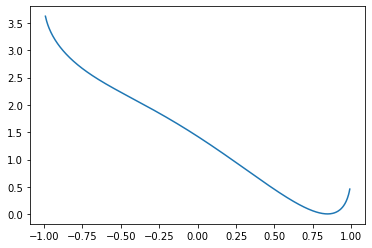

In [99]:
rho_arr = np.linspace(-.99,.99, 500)
l_arr = []
for rho in rho_arr:
    l_arr.append(fn(rho))
plt.plot(rho_arr, l_arr)
rho_arr[np.argmin(l_arr)]

In [43]:
Gaussian(0.8, stats.uniform, stats.uniform).canonical_calibrate(u_arr, v_arr)

Optimization terminated successfully.
         Current function value: -0.436606
         Iterations: 32
         Function evaluations: 68


array([0.76821375])

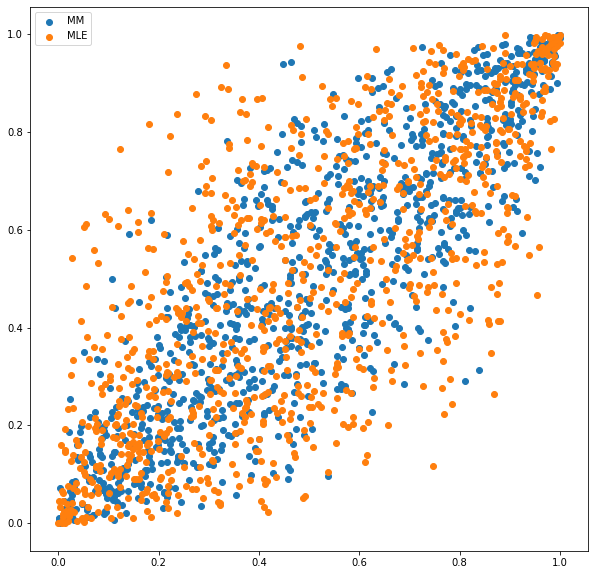

In [93]:
s0 = Gaussian(0.88, stats.uniform, stats.uniform).sample(1000)
s1 = Gaussian(0.76, stats.uniform, stats.uniform).sample(1000)

plt.figure(figsize=(10,10))
plt.scatter(s0[:,0],s0[:,1], label="MM")
plt.scatter(s1[:,0],s1[:,1], label="MLE")
plt.legend()

In [115]:
fn     = lambda para: loss(t_Copula(para[0], para[1], stats.uniform, stats.uniform))
result = scipy.optimize.fmin(fn,x0=(0.7, 4))

KeyboardInterrupt: 

In [118]:
C = t_Copula(0.2, 10, stats.uniform, stats.uniform)

0.29683677838818695

In [120]:
%%time
C._lambda(0.9)

CPU times: user 2.14 s, sys: 32.4 ms, total: 2.17 s
Wall time: 2.19 s


0.19889838031938117

In [121]:
C.canonical_calibrate(u_arr, v_arr)

Optimization terminated successfully.
         Current function value: -0.515522
         Iterations: 152
         Function evaluations: 300


array([2.        , 0.77581356])

In [51]:
%%time 
fn((0.7,10))

CPU times: user 9.26 s, sys: 42 ms, total: 9.3 s
Wall time: 9.32 s


0.2808874816650633

In [63]:
fn = lambda theta: loss(Clayton(theta, stats.uniform, stats.uniform))
result = scipy.optimize.fmin(fn,x0=10)
print(result)

AttributeError: 'Clayton' object has no attribute 'tau'

In [69]:
fn = lambda theta: loss(Frank(theta, stats.uniform, stats.uniform))
result = scipy.optimize.fmin(fn,x0=(10))
print(result)

ValueError: cannot reshape array of size 49 into shape (1,7)

In [27]:
theta_arr = np.linspace(0.1,40,500)
loss_arr = []
for theta in theta_arr:
    loss_arr.append(fn(theta))

Text(0, 0.5, 'loss')

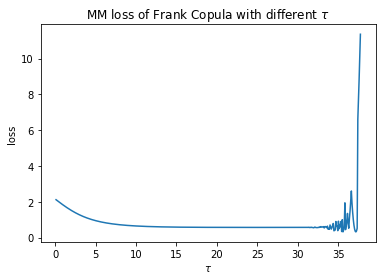

In [71]:
plt.title(r"MM loss of Frank Copula with different $\tau$")
plt.plot(theta_arr, loss_arr)
plt.xlabel(r'$\tau$')
plt.ylabel('loss')

In [ ]:
fn = lambda theta: loss(Gumbel(theta, stats.uniform, stats.uniform))
result = scipy.optimize.fmin(fn,x0=1)
print(result)

In [20]:
C = Gaussian(0.2,stats.uniform, stats.uniform)

# C = t_Copula(0.2,10,stats.uniform, stats.uniform)

# C = Clayton(0.1, stats.uniform, stats.uniform)
# C = Frank(0.1, stats.uniform, stats.uniform)
# C = Clayton(0.1, stats.uniform, stats.uniform)



samples = C.sample(1000000)
print("\nlambda from sample:",
      empirical_lambda(samples[:,0], samples[:,1],0.2),
      "\nlambda analytical :",
       C._lambda(0.2))


lambda from sample: 1.83007 
lambda analytical : 0.2840745490467395


In [21]:
C.tau()

0.12818843369794988

In [22]:
stats.kendalltau(samples[:,0], samples[:,1])[0]

0.12721208688808688

In [210]:
C1 = Gaussian( 0.90, stats.uniform, stats.uniform)
# C2 = Gaussian(-0.01, stats.uniform, stats.uniform)
C2 = Gaussian(0, stats.uniform, stats.uniform)


In [283]:
size1

73078.0

In [290]:
result = np.array([0.9263482 , 0.73078416])
C1 = Gaussian( result[0], stats.uniform, stats.uniform)
p     = result[1]
size  = len(u_arr)
size1 = int(round(size*p))
size2 = size - size1

samples = np.zeros((size,2))

samples[:size1,:] = C1.sample(size1)
samples[size1:,:] = C2.sample(size2)

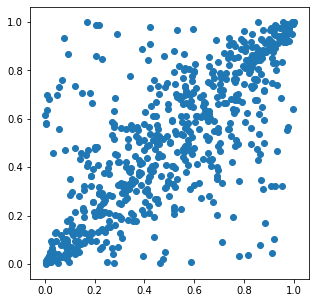

In [291]:
plt.figure(figsize=(5,5))
plt.scatter(samples[:,0], samples[:,1])

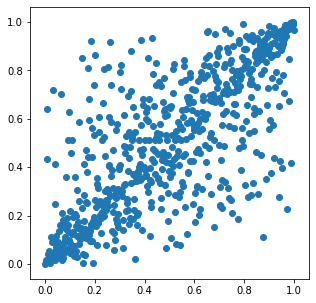

In [292]:
plt.figure(figsize=(5,5))
plt.scatter(u_arr, v_arr)

In [253]:
# test on pi! --> if pi > 0, there is idioscyratic risk

mixture_C = lambda u,v: p*C1.C(u,v) + (1-p)*C2.C(u,v)
mixture_c = lambda u,v: p*C1.c(u,v) + (1-p)*C2.c(u,v)

In [251]:
q1 = 0.9
q2 = 0.2

mixture_C(q1,q2)

0.19799996779730517

In [252]:
np.mean((samples[:,0] <=q1) & (samples[:,1] <=q2))

0.19808

In [261]:
class mixture_Copula:
    def __init__(self, C1, C2, p):
        self.C1 = C1
        self.C2 = C2
        self.p = p
    def C(self, u, v):
        return  self.p*self.C1.C(u,v) + (1-self.p)*self.C2.C(u,v)
        
    def c(self, u, v):
        return  self.p*self.C1.c(u,v) + (1-self.p)*self.C2.c(u,v)

In [278]:
def loss(rho, p, u_arr, v_arr):
    if np.abs(rho) >=0.99:
        return 5000
    if (p<0) & (p>=1):
        return 5000
    densities = []
    C1 = Gaussian(rho, stats.uniform, stats.uniform)
    # C2 = Gaussian(-0.01, stats.uniform, stats.uniform)
    C2 = Gaussian(0, stats.uniform, stats.uniform)

    for i in range(len(u_arr)):
        densities.append(mixture_Copula(C1, C2, p).c(u_arr[i], v_arr[i]))
    return -np.nanmean(np.log(np.array(densities)))

In [272]:
loss_arr =[]
p_arr = np.linspace(0,1,100)

for p in p_arr:
    loss_arr.append(loss(0.9, p, u_arr, v_arr))

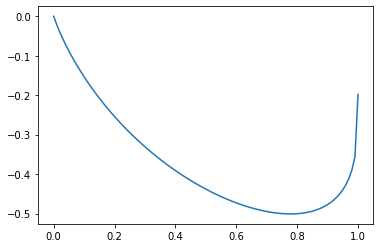

In [273]:
plt.plot(p_arr, loss_arr)

In [279]:
fn = lambda para: loss(para[0],para[1], u_arr, v_arr)

In [280]:
scipy.optimize.fmin(fn, x0=(0.5,0.5))

Optimization terminated successfully.
         Current function value: -0.505570
         Iterations: 62
         Function evaluations: 118


array([0.9263482 , 0.73078416])

In [302]:
def loss1(rho1, rho2, p, u_arr, v_arr):
    if (rho1 > 0.99) or (rho1 < 0.001):
        return 5000
    if (rho2 < -0.99) or (rho2 > -0.001):
        return 5000
    if (p<0) & (p>=1):
        return 5000
    
    densities = []
    C1 = Gaussian(rho1, stats.uniform, stats.uniform)
    C2 = Gaussian(rho2, stats.uniform, stats.uniform)

    for i in range(len(u_arr)):
        densities.append(mixture_Copula(C1, C2, p).c(u_arr[i], v_arr[i]))
    return -np.nanmean(np.log(np.array(densities)))

In [303]:
fn = lambda para: loss1(para[0],para[1], para[2], u_arr, v_arr)

In [305]:
scipy.optimize.fmin(fn, x0=(0.9,-0.9,0.5))

Optimization terminated successfully.
         Current function value: -0.505530
         Iterations: 85
         Function evaluations: 150


array([ 0.92619524, -0.00100101,  0.73194971])

In [310]:
T = t_Copula(0.9,10,stats.uniform, stats.uniform).canonical_calibrate(u_arr, v_arr, nu_lowerbound=3.9)

Optimization terminated successfully.
         Current function value: -0.503698
         Iterations: 159
         Function evaluations: 303


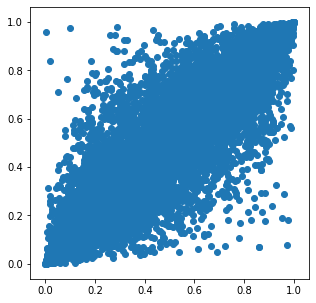

In [324]:
T = t_Copula(0.9,4,stats.uniform, stats.uniform)
s = T.sample(10000)

plt.figure(figsize=(5,5))
plt.scatter(s[:,0],s[:,1])

0.00040287961209075306

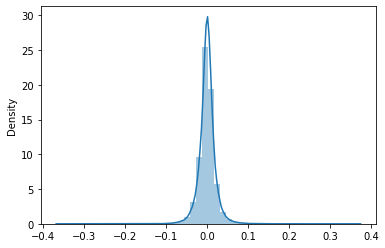

In [399]:
s = T.sample(1000000)
rs = np.quantile(data.return_brr, s[:,0])
rf = np.quantile(data.return_btc, s[:,1])
h=0.99
rh = rs - h*rf
sns.distplot(rh)
np.var(rh)

In [403]:
%%time 
fn = lambda x: T.f_RH(1,x)
scipy.integrate.quad(fn, -np.inf, 0)

KeyboardInterrupt: 

In [405]:
%%time
T.F_RH(1,0)

CPU times: user 6.14 s, sys: 23.2 ms, total: 6.16 s
Wall time: 6.17 s


0.500712613672565

CPU times: user 4.7 s, sys: 543 ms, total: 5.25 s
Wall time: 4.05 s


0.00040441372860227227

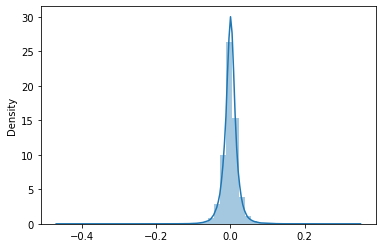

In [413]:
%%time
s = T.sample(1000000)
rs = kde_brr.ppf(s[:,0])
rf = kde_btc.ppf(s[:,1])
h=0.99
rh = rs - h*rf
sns.distplot(rh)
np.var(rh)

0.00040330205090227325

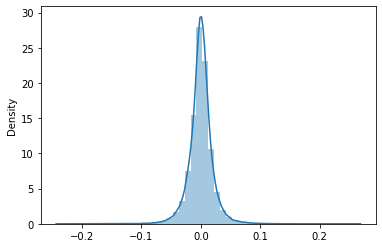

In [439]:
s = T.sample(100000)
rs = kde_brr.ppf(s[:,0])
rf = kde_btc.ppf(s[:,1])
h=0.99
rh = rs - h*rf
sns.distplot(rh)
np.var(rh)

In [447]:
result = []
h_arr = np.linspace(0.75,.85,20)

for h in h_arr:
    print(h)
    rh = rs - h*rf
    n=200000
    q_arr = np.linspace(0,1,n)
    toin = ERM_weight(k=10,s=q_arr) * np.quantile(rh, q_arr)
    result.append(-np.sum((toin[1:] + toin[:-1])/n/2))

0.75
0.7552631578947369
0.7605263157894737
0.7657894736842106
0.7710526315789473
0.7763157894736842
0.781578947368421
0.7868421052631579
0.7921052631578948
0.7973684210526316
0.8026315789473684
0.8078947368421052
0.8131578947368421
0.8184210526315789
0.8236842105263158
0.8289473684210527
0.8342105263157895
0.8394736842105263
0.8447368421052631
0.85


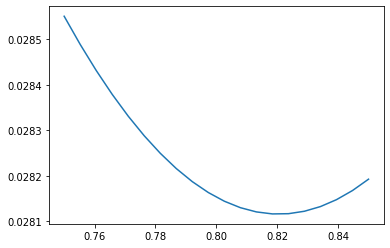

In [448]:
plt.plot(h_arr, result)

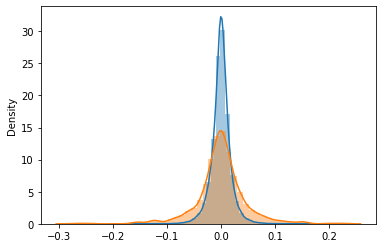

In [459]:
rh = rs - h_arr[np.argmin(result)]*rf
sns.distplot(rh)
sns.distplot(kde_btc.rvs(100000))

In [415]:
def ERM_weight(k,s):
    return k*np.exp(-k*s)/(1-np.exp(-k))

k=10
fn = lambda q: ERM_weight(k,q) * np.quantile(rh,q)


(-0.030739351072433637, 3.1261915835103377e-05)

In [416]:
%%time 
scipy.integrate.quad(fn, 0,1)

CPU times: user 19.3 s, sys: 26.1 ms, total: 19.3 s
Wall time: 19.4 s


(-0.030739351072433637, 3.1261915835103377e-05)

0.00039273257544165013

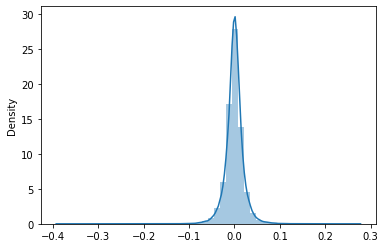

In [409]:
s = T.sample(100000)
rs = kde_brr.ppf(s[:,0])
rf = kde_btc.ppf(s[:,1])
h=0.99
rh = rs - h*rf
sns.distplot(rh)
np.var(rh)

In [408]:
kde_brr.ppf(s[:,0])

array([-0.00452449, -0.01350494, -0.00173958, ...,  0.00651001,
       -0.01400416,  0.02463171])

In [35]:
C1 = t_Copula(0.7,4, stats.norm, stats.norm)
C1 = Gaussian(0.7, stats.norm, stats.norm)

fn = lambda q: C1.c(q,1-q)

In [36]:
scipy.integrate.quad(fn, 0,1)

(0.5882352941167336, 2.930648373509457e-11)

In [37]:
q_arr = np.linspace(0,1,100)
result = []
for q in q_arr:
    result.append(fn(q))

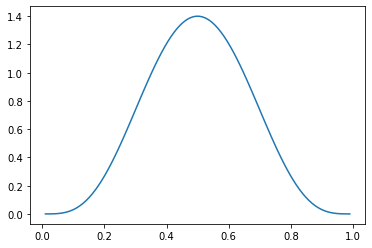

In [38]:
plt.plot(q_arr, result)

In [5]:
class Copula(object):
    def __init__(self):
        return
    
    def H(self, w, h, r_h): # a helper function to compute the input to F_RF
        A = self.Law_RS.ppf(w) - r_h
        if h!=0:
            B = h
        else:
            B = 0.00001
        return A/B
    
    def g(self, w, h, r_h):
        return self.Law_RF.cdf(self.H(w=w, h=h, r_h=r_h))
    
    def F_RH(self, h, r_h):
        func = partial(self.D1C, h=h, r_h=r_h)
        I = integrate.quad(func, 0.0001, 0.999)
        return 1 - I[0]
    
    def f_RH(self, h, r_h):
        part1 = lambda u: self.c(u, self.g(w=u, h=h, r_h=r_h))
        part2 = lambda u: self.Law_RF.pdf(self.H(w=u, h=h, r_h=r_h))
        integrand = lambda u: part1(u)*part2(u)
        return integrate.quad(integrand, 0.0001, 0.999)[0]/np.abs(h)
        
    def _lambda(self, q):
        if q<= 0.5:
            return self.C(q,q)/q
        else:
            return (1-(2*q)+self.C(q,q) )/(1-q)
        
class Gaussian_Mix_Independent(Copula):
    def __init__(self, rho, p, Law_RS, Law_RF):
        self.rho = rho
        self.p   = p
        self.Gaussian    = Gaussian(rho, Law_RS, Law_RF)
        self.Independent = Gaussian(0, Law_RS, Law_RF)
        self.Law_RS = Law_RS   # Marginal Distribution of Spot
        self.Law_RF = Law_RF   # Marginal Distribution of Future
        
    def C(self, u,v):
        return p*self.Gaussian.c(u,v) + (1-p)*self.Independent.c(u,v)

    def c(self, u,v):
        return self.p*self.Gaussian.c(u,v) + (1-self.p)
    
    def D1C(self, w, h, r_h):
        return self.p*self.Gaussian.D1C(w,h,r_h) + (1-self.p)*self.g(w,h,r_h)
    
    def l_fn(self, rho, p, u, v):
        if (p < 0) or (p >1) or (np.abs(rho)>.999):
            return -5000
        _Gaussian    = Gaussian(rho, stats.norm, stats.norm)
        _Gaussian_c = np.array([_Gaussian.c(u[i],v[i]) for i in range(len(u))])
        return np.nanmean(np.log(p*_Gaussian_c + (1-p)))
        
    def canonical_calibrate(self, u, v):
        fn_toopt = lambda para: -self.l_fn(para[0],para[1], u, v)
        result = scipy.optimize.fmin(fn_toopt, x0=(self.rho, self.p), 
                             xtol=1e-10, 
                             maxiter=5000,
                             maxfun=400)
        self.rho = result[0]
        self.p   = result[1]
        self.Gaussian = Gaussian(self.rho, self.Law_RS, self.Law_RF)   
        return result
    
    def sample(self, size):
        samples = np.zeros((size, 2))
        n_Gaussian = int(self.p * size)
        n_Independent = size - n_Gaussian
        samples[:n_Gaussian,:] = self.Gaussian.sample(n_Gaussian)
        
        I1 = self.Law_RS.ppf(stats.uniform.rvs(size=n_Independent))
        I2 = self.Law_RF.ppf(stats.uniform.rvs(size=n_Independent))

        samples[n_Gaussian:,0] = I1
        samples[n_Gaussian:,1] = I2
        
        return samples

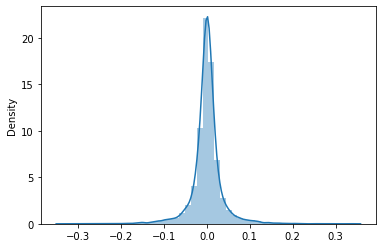

In [6]:
C = Gaussian_Mix_Independent(0.92634429,0.73081241,kde_brr, kde_btc)
s = C.sample(10000)
h=1
rh = s[:,0] - h*s[:,1]
x_arr = np.linspace(min(rh),max(rh),100)
sns.distplot(rh)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


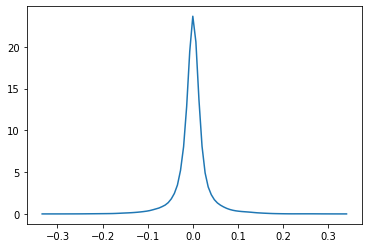

In [7]:
result =[]
for i,x in enumerate(x_arr):
    print(i)
    result.append(C.f_RH(1,x))
plt.plot(x_arr, result)

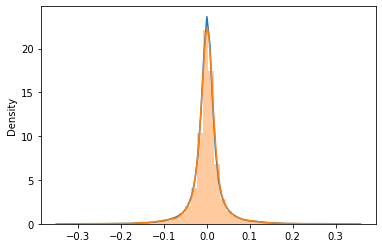

In [9]:
plt.plot(x_arr, result)
sns.distplot(rh)

In [18]:
T = t_Copula(0.7,4,stats.uniform, stats.uniform)
T.c(.0001,.0001)

1858.2119086518817

In [73]:
u  = .99
X1 = norm.ppf(u)
X2 = norm.ppf(u)
Gaus.meta_Gaussian.pdf((X1,X2))/(norm.pdf(X1)*norm.pdf(X2))

29.781712910901764

In [53]:
Gaus.meta_Gaussian.pdf((-10,-10))

5.068028173248789e-24

In [174]:
integrate.quad(integrand, 0.01, 0.999)

(0.0309066832917459, 0.0006603893221423414)

In [96]:
C.canonical_calibrate(u_arr, v_arr)

Optimization terminated successfully.
         Current function value: -0.505570
         Iterations: 88
         Function evaluations: 183


array([0.92634429, 0.73081241])

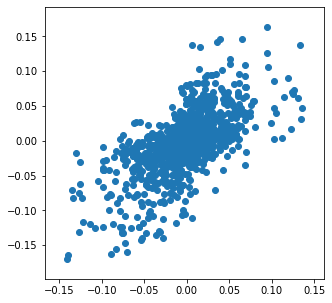

In [37]:
# C = Gaussian_Mix_Independent(0.92634429,0.73081241,kde_brr, kde_btc)
C = Gaussian(0.7,kde_brr, kde_btc)
s = C.sample(1000)
plt.figure(figsize=(5,5))
plt.scatter(s[:,0], s[:,1])
rh=s[:,0]-1*s[:,1]

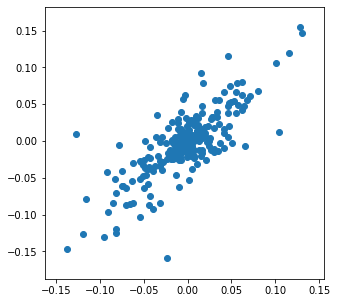

In [35]:
plt.figure(figsize=(5,5))
plt.scatter(data.return_brr.values, data.return_btc.values)

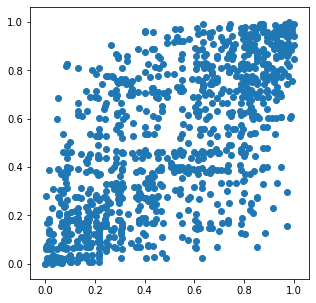

In [38]:
plt.figure(figsize=(5,5))
plt.scatter(kde_brr.cdf(s[:,0]),kde_btc.cdf(s[:,1]))

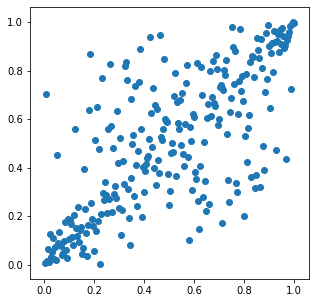

In [39]:
plt.figure(figsize=(5,5))
plt.scatter(u_arr, v_arr)

In [30]:
h = 1
rh = data.return_brr - h*data.return_btc

s = ECDF(rh)(rh)
w = ERM_weight(10,s)

C = t_Copula(0.7,4,kde_brr, kde_btc)

In [47]:
fn = lambda para: -np.nanmean([C.l_fn(para[0],para[1],[u_arr[i]], [v_arr[i]])*w[i] for i in range(len(u_arr))])

In [48]:
scipy.optimize.fmin(fn, (0.7,4))

Optimization terminated successfully.
         Current function value: -0.209857
         Iterations: 57
         Function evaluations: 113


array([ 0.44775967, 18.41123255])

In [2]:
C = t_Copula(0.44775967,18.41123255,kde_brr, kde_btc)

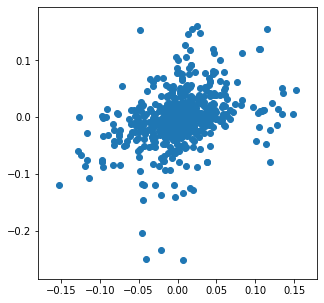

In [8]:
s = C.sample(len(u_arr))
plt.figure(figsize=(5,5))
plt.scatter(s[:,0],s[:,1])

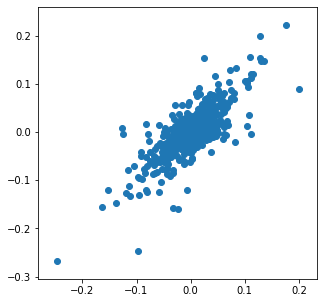

In [7]:
plt.figure(figsize=(5,5))
plt.scatter(data.return_brr,data.return_btc)

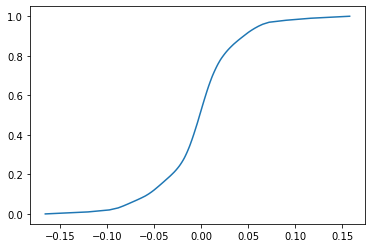

In [40]:
q_arr = np.linspace(0,1,100)
plt.plot(kde_brr.ppf(q_arr),q_arr)

In [54]:
a = min(data.return_brr)-np.std(data.return_brr)
b = max(data.return_brr)+np.std(data.return_brr)

x_arr = np.linspace(a,b,10000)

result = []

for x in x_arr:
    result.append(kde_brr.pdf(x))

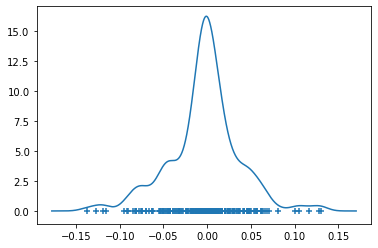

In [55]:
plt.plot(x_arr, result)
plt.scatter(data.return_brr,np.zeros(len(u_arr)), marker='+')

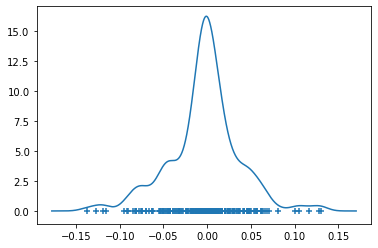

In [2]:
kde_brr.plot_density()

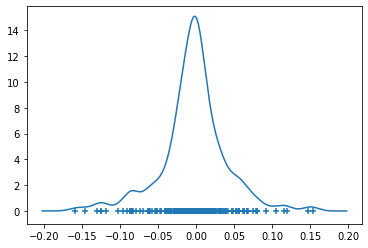

In [3]:
kde_btc.plot_density()

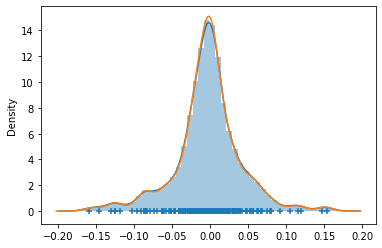

In [7]:
sns.distplot(kde_btc.rvs(100000))
kde_btc.plot_density()

In [30]:
bw      = KDE(data.return_btc.values, "Gaussian").h_brot*2
kde_brr = KDE(data.return_brr.values, "Gaussian", bw=bw)
kde_btc = KDE(data.return_btc.values, "Gaussian", bw=bw)

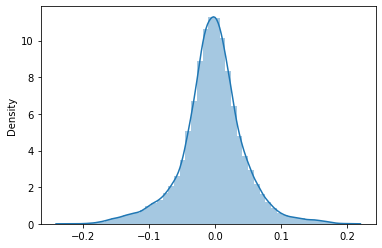

In [32]:
# sns.distplot(data.return_btc.values)
sns.distplot(kde_btc.rvs(100000))
# kde_btc.plot_density()

In [18]:
uq   = np.quantile(data.return_btc.values, .75)
lq   = np.quantile(data.return_btc.values, .25)
1.06*min(np.std(data.return_btc.values), (uq-lq)/1.34)*len(data.return_btc.values)**(-1/5)

0.009327681117608606

In [40]:
%%time

multivariate_t(10,
               np.array([[1,0],
                         [0,1]])).cdf(np.array([10,10]))

CPU times: user 5.07 s, sys: 30.5 ms, total: 5.1 s
Wall time: 5.13 s


0.9999984175568303

In [78]:
from scipy.special import gamma
nu=9
rho = 0.5


def x(m,y1,y2):
    part1 = (y1-rho*y2)**2
    part2 = (y1-rho*y2)**2 + (1-rho**2)*(m+y2**2)
    return part1/part2

def I(m,y1,y2,a,b):
    part1 = gamma(a+b)/(gamma(a)*gamma(b))
    fn = lambda y: y**(a-1)*(1-y)**(b-1)
    part2 = scipy.integrate.quad(fn, 0, x(m,y1,y2))[0]
    return part1*part2
    
def cdf(y1,y2,nu,rho): # for odd nu
    part1  = 1/(2*np.pi)*np.arctan(-np.sqrt(1-rho**2)/rho)
    
    part2 = []
    for j in range(1, int(nu/2)):  
        part2a = gamma(j-0.5)/gamma(j)*(1+y2**2/nu)**(0.5-j) 
        part2b = 1+np.sign(y1-rho*y2)*I(nu,y1,y2,0.5,j-0.5)
        part2.append(part2a*part2b)
    
    part2 =  y2/(4*np.sqrt(nu*np.pi))*sum(part2)    
    
    part3 = []
    for j in range(1, int(nu/2)):
        part3a = gamma(j-0.5)/gamma(j)*(1+y1**2/nu)**(0.5-j)
        part3b = 1+np.sign(y2-rho*y1)*I(nu,y2,y1,0.5,j-0.5)
        part3.append(part3a*part3b)
    part3 =  y1/(4*np.sqrt(nu*np.pi))*sum(part3)
    
    return part1 + part2 + part3
    
    

In [81]:
cdf(0,0,9,0.5)

ZeroDivisionError: 0.0 cannot be raised to a negative power

In [76]:
def cdf(y1,y2,nu,rho): # for odd nu
    alpha = y1+y2
    beta = y1*y2 - rho*nu
    gam = y1*y2-nu
    delta = np.sqrt(y1**2-2*rho*y1*y2+y2**2+nu*(1-rho**2))
    
    part1 = 1/(2*np.pi)*np.arctan(-np.sqrt(nu)*( (alpha*beta+gam*delta) / (gam*beta-nu*alpha*delta)))
    
    part2 = []
    for j in range(1, int(nu/2)):  
        part2a = gamma(j-0.5)/gamma(j)*(1+y2**2/nu)**(0.5-j) 
        part2b = 1+np.sign(y1-rho*y2)*I(nu,y1,y2,0.5,j-0.5)
        part2.append(part2a*part2b)
    
    part2 =  y2/(4*np.sqrt(nu*np.pi))*sum(part2)    
    
    part3 = []
    for j in range(1, int(nu/2)):
        part3a = gamma(j-0.5)/gamma(j)*(1+y1**2/nu)**(0.5-j)
        part3b = 1+np.sign(y2-rho*y1)*I(nu,y2,y1,0.5,j-0.5)
        part3.append(part3a*part3b)
    part3 =  y1/(4*np.sqrt(nu*np.pi))*sum(part3)
    
    return part1 + part2 + part3
    
    
    
    

In [77]:
cdf(0.001,0.001,10,0.5)

0.16711377252358303

In [75]:
rho=-0.9
np.arctan(np.sqrt(1-rho**2)/(rho))

-0.45102681179626236

In [86]:
Sigma = np.array([[1,rho],[rho,1]])
MN = stats.multivariate_normal([0,0], 
                               Sigma)

In [90]:
gamma((nu+2)/2)/gamma(nu/2)*np.sqrt(np.linalg.det(Sigma)*(nu*np.pi)**2)

110.18831137722871

In [132]:
%%time
b = np.array([-1,1])
rho=0.9
nu=1.08
Sigma = np.array([[1,rho],[rho,1]])
MN = stats.multivariate_normal([0,0], 
                               Sigma)
for i in range(100):
    fn = lambda s: s**(nu-1)*np.exp(-s**2/2)*MN.cdf(s*b/np.sqrt(nu))
    (2**(1-(nu/2))/gamma(nu/2)*scipy.integrate.quad(fn, 0, np.inf)[0])
print( (2**(1-(nu/2))/gamma(nu/2)*scipy.integrate.quad(fn, 0, np.inf)[0]))

0.23792343468303542
CPU times: user 1.52 s, sys: 126 ms, total: 1.64 s
Wall time: 1.58 s


In [133]:

MT = multivariate_t(nu, Sigma)
MT.cdf(b)

0.2378367479001675

In [121]:
stats.t(df=10).cdf(0)

0.5

0.7290929595946272